# Teste Completo do Pipeline de PDI 

Este notebook demonstra o fluxo completo do processamento de imagens, desde o pré-processamento até a extração de características.

**Fluxo de Teste:**
1.  **Carregar Imagem**
2.  **Etapa 1: Pré-processamento** (`preprocessing.py`)
3.  **Etapa 2: Segmentação** (`segmentation.py`)
4.  **Etapa 3: Características Geométricas** (`geometric.py`)
5.  **Etapa 4: Características de Forma/Textura** (`features.py`, `textura.py`)
6.  **Conclusão e Visualização Final**

Imagem carregada: ../../dataset_test/Banana/1.jpg (Dimensões: (183, 275, 3))


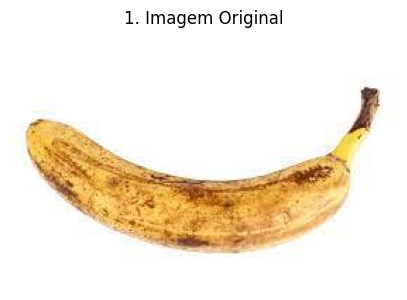

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import converter_para_cinza, aplicar_filtro_gaussiano, detectar_bordas_canny

from segmentation import segmentar_objeto_com_flood_fill, filtrar_contornos_borda, encontrar_contornos, desenhar_contornos

from geometric import calcular_area, calcular_perimetro, calcular_circularidade, calcular_aspect_ratio

from features import extrair_caracteristicas_forma, extrair_lbp, extrair_glcm, extrair_hog


# Carregar Imagem de Teste

caminho_imagem = '../../dataset_test/Banana/1.jpg'

img_original = cv2.imread(caminho_imagem)

img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

print(f"Imagem carregada: {caminho_imagem} (Dimensões: {img_original.shape})")
    
plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.title("1. Imagem Original")
plt.axis('off')
plt.show()

## Etapa 1: Pré-processamento

**O que faz:** Limpa a imagem, converte para escala de cinza e aplica filtros para reduzir ruído.


Etapa 1 (Pré-processamento) concluída.


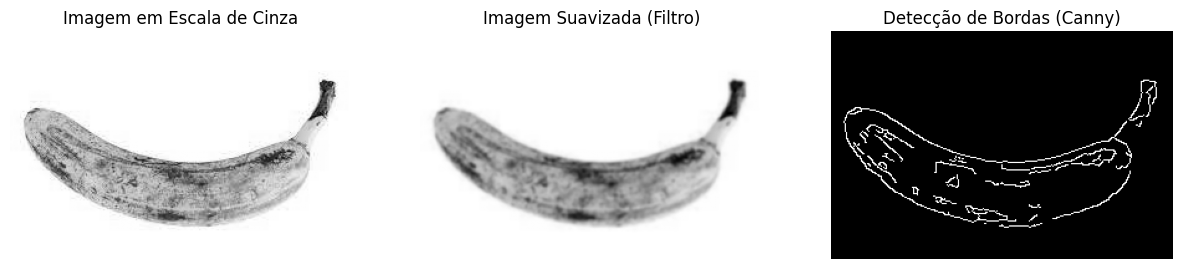

In [25]:
# Executando Pré-processamento ---


img_cinza = converter_para_cinza(img_original)
img_suavizada = aplicar_filtro_gaussiano(img_cinza)
img_bordas_canny = detectar_bordas_canny(img_suavizada) 

print("Etapa 1 (Pré-processamento) concluída.")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_cinza, cmap='gray')
plt.title("Imagem em Escala de Cinza")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_suavizada, cmap='gray')
plt.title("Imagem Suavizada (Filtro)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_bordas_canny, cmap='gray')
plt.title("Detecção de Bordas (Canny)")
plt.axis('off')

plt.show()

## Etapa 2: Segmentação

**O que faz:** Isola a fruta (objeto de interesse) do fundo. Gera uma máscara binária e o contorno principal.


Etapa 2 (Segmentação) concluída.


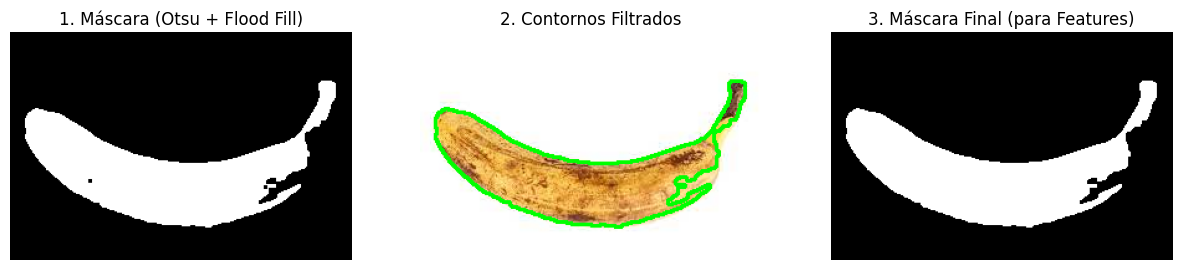

In [26]:


mascara_segmentada = segmentar_objeto_com_flood_fill(img_suavizada)

contornos = encontrar_contornos(mascara_segmentada)

altura_img, largura_img = img_cinza.shape

contornos_filtrados = filtrar_contornos_borda(contornos, largura_img, altura_img)

mascara_final = np.zeros_like(img_cinza)


cv2.drawContours(mascara_final, contornos_filtrados, -1, (255), -1)


img_com_contornos = desenhar_contornos(img_rgb, contornos_filtrados, cor=(0, 255, 0), espessura=2)

print("Etapa 2 (Segmentação) concluída.")

# --- Visualização ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mascara_segmentada, cmap='gray')
plt.title("1. Máscara (Otsu + Flood Fill)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_com_contornos) # Mostra a imagem RGB com o contorno
plt.title("2. Contornos Filtrados")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mascara_final, cmap='gray')
plt.title("3. Máscara Final (para Features)")
plt.axis('off')

plt.show()

# --- IMPORTANTE para a próxima etapa (Geometria) ---
# Guardamos o contorno principal (o maior) dos contornos filtrados.
if contornos_filtrados:
    contorno_principal = max(contornos_filtrados, key=cv2.contourArea)
else:
    contorno_principal = None

## Etapa 3: Características Geométricas 

**O que faz:** Calcula as métricas de geometria (Área, Perímetro, Circularidade) usando o contorno da fruta.


In [27]:

metricas_geo = {} # Dicionário para guardar os resultados

if contorno_principal is not None:
    # Calculamos cada métrica individualmente
    area = calcular_area(contorno_principal)
    perimetro = calcular_perimetro(contorno_principal)
    circularidade = calcular_circularidade(contorno_principal)
    aspect_ratio = calcular_aspect_ratio(contorno_principal)
    
    print("--- Métricas Geométricas ---")
    print(f"Área: {area} pixels")
    print(f"Perímetro: {perimetro:.2f} pixels")
    print(f"Circularidade: {circularidade:.4f}")
    print(f"Aspect Ratio (L/A): {aspect_ratio:.4f}")
    
    # Guarda no dicionário para a visualização final
    metricas_geo = {
        'area': area,
        'perimetro': perimetro,
        'circularidade': circularidade,
        'aspect_ratio': aspect_ratio
    }
    
else:
    print("ERRO: Nenhum contorno encontrado na Etapa 2. Geometria não pode ser calculada.")
    metricas_geo = {
        'area': 'N/A',
        'perimetro': 'N/A',
        'circularidade': 'N/A',
        'aspect_ratio': 'N/A'
    }

--- Métricas Geométricas ---
Área: 11054.5 pixels
Perímetro: 807.80 pixels
Circularidade: 0.2129
Aspect Ratio (L/A): 2.1186


##  Etapa 4: Características de Textura e Forma

**O que faz:** Calcula os vetores de características finais (HOG, LBP, GLCM) da imagem em escala de cinza. Estes são os valores que serão usados para treinar o modelo.


Iniciando Etapa 4 (Features)...
Etapa 4 (Features) concluída.

--- Resultados HOG ---
Tamanho do Vetor HOG: (5760,)

--- Resultados LBP ---
Tamanho do Histograma LBP: (10,)

--- Resultados GLCM (média) ---
Contraste: 306.4970
Energia: 0.6253
Homogeneidade: 0.7016
Correlação: 0.9071


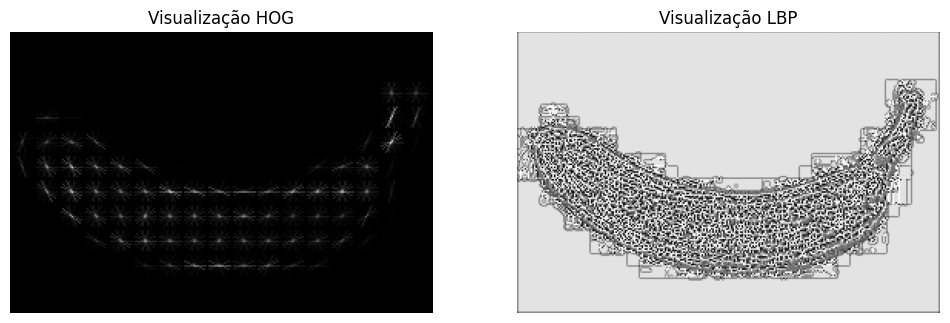

In [28]:

print("Iniciando Etapa 4 (Features)...")

vetor_hog, img_visual_hog = extrair_hog(img_cinza) 

img_visual_lbp, hist_lbp = extrair_lbp(img_cinza)

metricas_glcm = extrair_glcm(img_cinza)

print("Etapa 4 (Features) concluída.")


print("\n--- Resultados HOG ---")
print(f"Tamanho do Vetor HOG: {vetor_hog.shape}")

print("\n--- Resultados LBP ---")
print(f"Tamanho do Histograma LBP: {hist_lbp.shape}")

print("\n--- Resultados GLCM (média) ---")
print(f"Contraste: {metricas_glcm.get('contrast', 'N/A'):.4f}")
print(f"Energia: {metricas_glcm.get('energy', 'N/A'):.4f}")
print(f"Homogeneidade: {metricas_glcm.get('homogeneity', 'N/A'):.4f}")
print(f"Correlação: {metricas_glcm.get('correlation', 'N/A'):.4f}")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_visual_hog, cmap='gray')
plt.title("Visualização HOG")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_visual_lbp, cmap='gray')
plt.title("Visualização LBP")
plt.axis('off')

plt.show()

## Conclusão e Visualização Final

Resumo visual de todo o processo para esta imagem de teste.

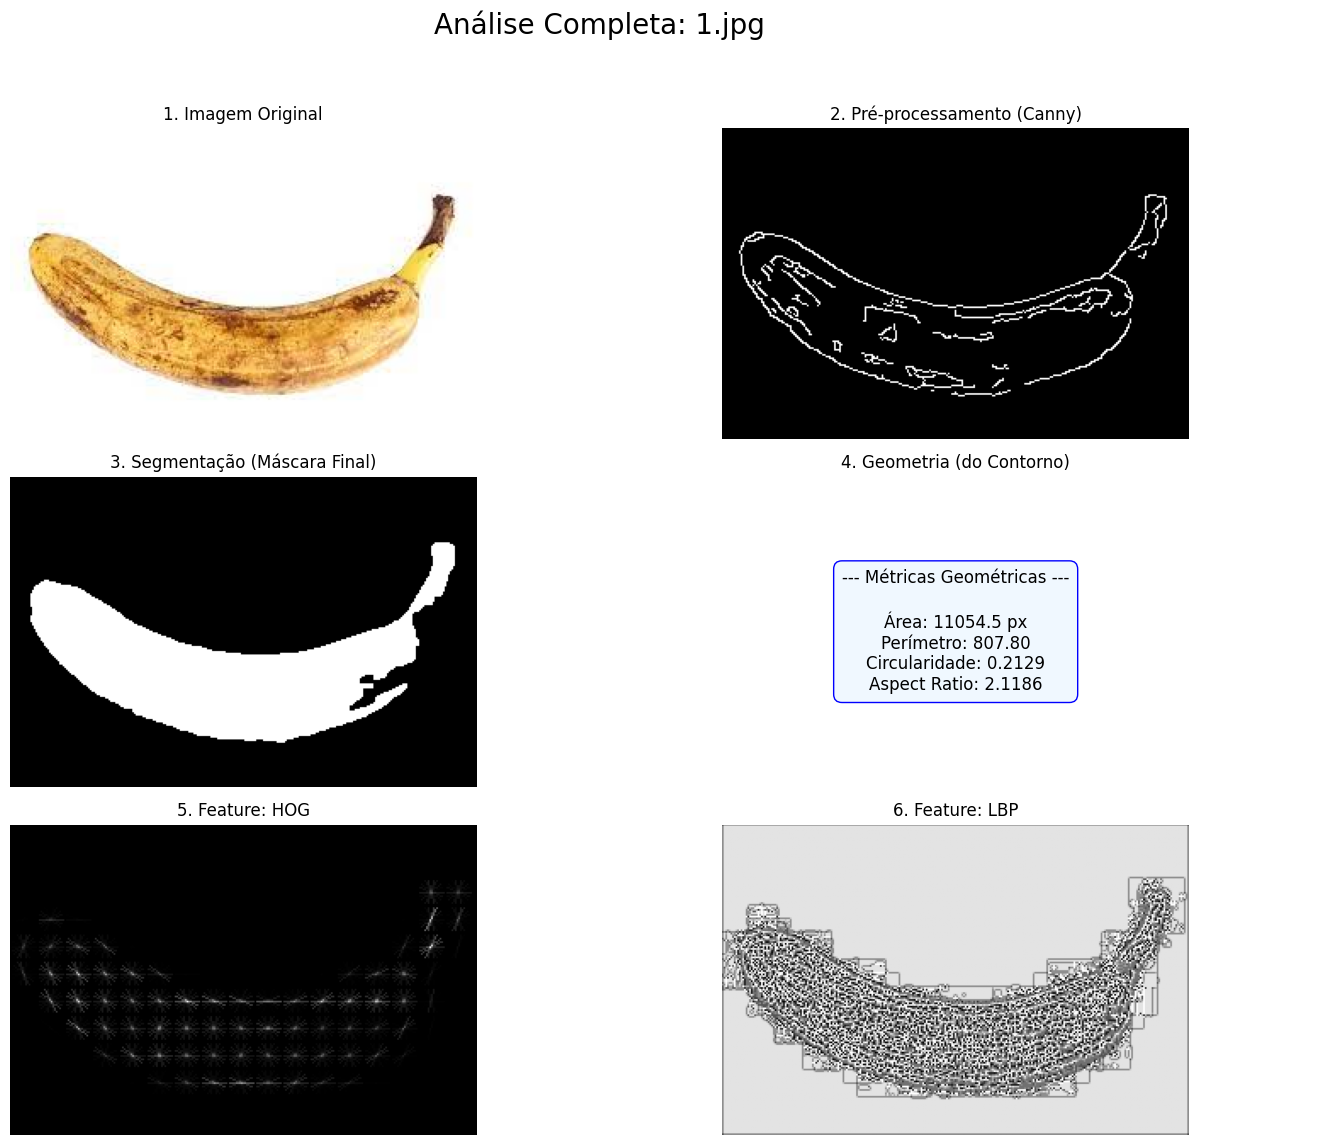

In [ ]:

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.imshow(img_rgb)
plt.title("1. Imagem Original")
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(img_bordas_canny, cmap='gray')
plt.title("2. Pré-processamento (Canny)")
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(mascara_final, cmap='gray')
plt.title("3. Segmentação (Máscara Final)")
plt.axis('off')

plt.subplot(3, 2, 4)
plt.axis('off')
geo_texto = f"--- Métricas Geométricas ---\n\n" \
            f"Área: {metricas_geo.get('area', 'N/A')} px\n" \
            f"Perímetro: {metricas_geo.get('perimetro', 'N/A'):.2f}\n" \
            f"Circularidade: {metricas_geo.get('circularidade', 'N/A'):.4f}\n" \
            f"Aspect Ratio: {metricas_geo.get('aspect_ratio', 'N/A'):.4f}"
plt.text(0.5, 0.5, geo_texto, ha='center', va='center', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.5", fc='aliceblue', ec='b', lw=1))
plt.title("4. Geometria (do Contorno)")


plt.subplot(3, 2, 5)
plt.imshow(img_visual_hog, cmap='gray')
plt.title("5. Feature: HOG")
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(img_visual_lbp, cmap='gray') 
plt.title("6. Feature: LBP")
plt.axis('off')

plt.suptitle(f"Análise Completa: {caminho_imagem.split('/')[-1]}", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()